# Assignment 2: Activation Functions
### CS60021: Scalable Data Mining
### Name: Bismay Parija
### Roll Number: 20CS30067

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston_target = raw_df.values[1::2, 2]

In [4]:
# Normalize features using mean-variance normalization
scaler = StandardScaler()
boston_data_normalized = scaler.fit_transform(boston_data)

In [5]:
# Convert to tensors
# X = torch.tensor(boston_data, dtype=torch.float32)
X = torch.tensor(boston_data_normalized, dtype=torch.float32)
# Reshape to (n_samples, 1)
y = torch.tensor(boston_target, dtype=torch.float32).view(-1, 1)
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### ReLU Model

In [27]:
class ReLUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ReLUModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, input):
        output = self.linear1(input)
        output = self.relu(output)
        output = self.linear2(output)
        return output

### Sigmoid Model

In [28]:
class SigmoidModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SigmoidModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, input):
        output = self.linear1(input)
        output = self.sigmoid(output)
        output = self.linear2(output)
        return output

### Swish Model

In [29]:
class SwishFunction(Function):
    @staticmethod
    def forward(ctx, input):
        sigmoid = torch.sigmoid(input)
        output = input * sigmoid
        ctx.save_for_backward(sigmoid, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        sigmoid, output = ctx.saved_tensors
        grad = sigmoid + output * (1 - sigmoid)
        return grad_output * grad


class Swish(nn.Module):
    def forward(self, input):
        return SwishFunction.apply(input)

In [30]:
class SwishModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SwishModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.swish = Swish()
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, input):
        output = self.linear1(input)
        output = self.swish(output)
        output = self.linear2(output)
        return output

### GELU Model

In [31]:
class GELUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        cdf = 0.5 * (1 + torch.erf(input / (2.0**0.5)))
        ctx.save_for_backward(input, cdf)
        return input * cdf

    @staticmethod
    def backward(ctx, grad_output):
        input, cdf = ctx.saved_tensors
        pdf = torch.distributions.Normal(0, 1).log_prob(input).exp()
        return grad_output * (cdf + input * pdf)


class GELU(nn.Module):
    def forward(self, input):
        return GELUFunction.apply(input)

In [32]:
class GELUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GELUModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.gelu = GELU()
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, input):
        output = self.linear1(input)
        output = self.gelu(output)
        output = self.linear2(output)
        return output

### Training Module

In [33]:
def train_model(model, optimizer, criterion, num_epochs=100, print_every=10):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        if (epoch + 1) % print_every == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}"
            )

    return train_losses, test_losses

### Initialization

In [100]:
# Initialize hyperparameters
input_size = X_train.shape[1]
hidden_size = 8
learning_rate = 0.001
momentum = 0.1
num_epochs = 50000
print_every = 5000

# Initialize models
relu_model = ReLUModel(input_size, hidden_size)
sigmoid_model = SigmoidModel(input_size, hidden_size)
swish_model = ReLUModel(input_size, hidden_size)
gelu_model = GELUModel(input_size, hidden_size)
models = [relu_model, sigmoid_model, swish_model, gelu_model]
activation_functions = ["ReLU", "Sigmoid", "Swish", "GELU"]

# Initialise optimizers
# SGD optimizers
sgd_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in models]

# Nesterov optimizers
nesterov_optimizers = [
    optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
    for model in models
]
# Adadelta optimizers
adadelta_optimizers = [
    optim.Adadelta(model.parameters(), lr=learning_rate) for model in models
]

# Define loss function
criterion = nn.MSELoss()

### Training

In [101]:
# Lists to store training and test losses
train_losses_list = []
test_losses_list = []

# Training loop for each model with the chosen optimizer
for i, model in enumerate(models):
    print(f"Using {activation_functions[i]} as the activation function:")
    # optimizer = sgd_optimizers[i]
    # optimizer = nesterov_optimizers[i]
    optimizer = adadelta_optimizers[i]
    train_losses, test_losses = train_model(
        model, optimizer, criterion, num_epochs, print_every
    )
    train_losses_list.append(train_losses)
    test_losses_list.append(test_losses)

Using ReLU as the activation function:
Epoch [5000/50000], Train Loss: 560.1656, Test Loss: 495.9907
Epoch [10000/50000], Train Loss: 219.5150, Test Loss: 185.8938
Epoch [15000/50000], Train Loss: 31.2187, Test Loss: 34.3083
Epoch [20000/50000], Train Loss: 22.4935, Test Loss: 26.3902
Epoch [25000/50000], Train Loss: 16.3490, Test Loss: 20.8096
Epoch [30000/50000], Train Loss: 12.5160, Test Loss: 16.8340
Epoch [35000/50000], Train Loss: 10.6633, Test Loss: 14.7536
Epoch [40000/50000], Train Loss: 9.5205, Test Loss: 13.4934
Epoch [45000/50000], Train Loss: 8.7614, Test Loss: 12.6149
Epoch [50000/50000], Train Loss: 8.3214, Test Loss: 12.2230
Using Sigmoid as the activation function:
Epoch [5000/50000], Train Loss: 588.4227, Test Loss: 519.0259
Epoch [10000/50000], Train Loss: 549.2199, Test Loss: 483.9271
Epoch [15000/50000], Train Loss: 477.5221, Test Loss: 418.3680
Epoch [20000/50000], Train Loss: 393.4187, Test Loss: 340.9468
Epoch [25000/50000], Train Loss: 312.4443, Test Loss: 265.

### Plotting

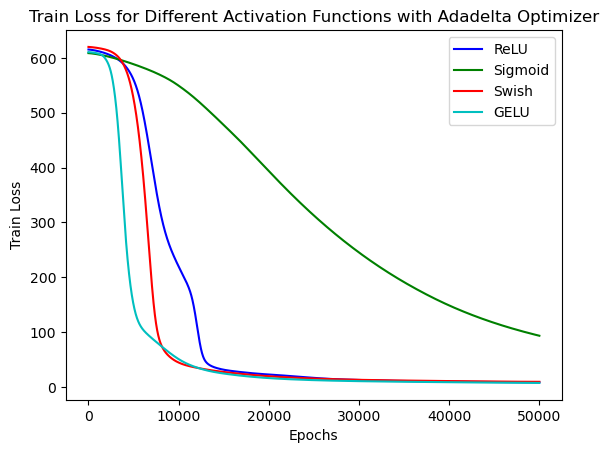

In [104]:
# Plot training losses for models with the chosen optimizer
colors = ["b", "g", "r", "c"]
for i, activation_function in enumerate(activation_functions):
    plt.plot(
        range(1, num_epochs + 1),
        train_losses_list[i],
        label=f"{activation_function}",
        color=colors[i],
    )

plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend()
# plt.title("Train Loss for Different Activation Functions with SGD Optimizer")
# plt.title("Train Loss for Different Activation Functions with Nesterov Optimizer")
plt.title("Train Loss for Different Activation Functions with Adadelta Optimizer")
plt.show()

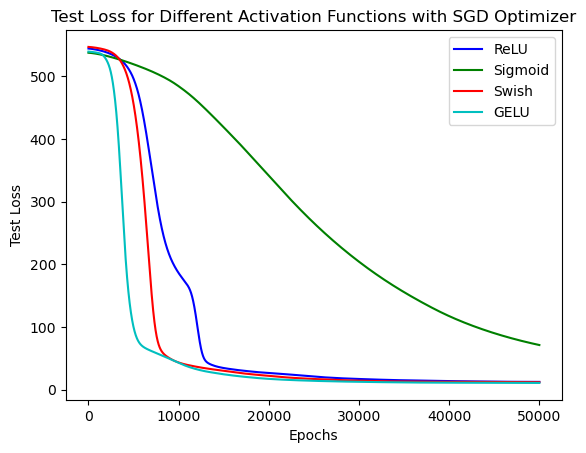

In [103]:
# Plot test losses for models with the chosen optimizer
for i, activation_function in enumerate(activation_functions):
    plt.plot(
        range(1, num_epochs + 1),
        test_losses_list[i],
        label=f"{activation_function}",
        color=colors[i],
    )

plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss for Different Activation Functions with SGD Optimizer")
# plt.title("Test Loss for Different Activation Functions with Nesterov Optimizer")
# plt.title("Test Loss for Different Activation Functions with Adadelta Optimizer")
plt.show()